# Implementation<br>


<div class="alert-danger">
1.First download the data to the file system from the link below.
    
- https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

    
---------------------------------------------------------------    
2.The dataset must be copied to the hapoop file system before implementation: 
    using the command line below

- Step 1: 'cd' to the location where the file is stored.<br>
example: cd C:\Users\user\Downloads<br><br>
    
- Step 2: hadoop fs -copyFromLocal localpath<br>
example: hadoop fs -copyFromLocal ./heart_2020_cleaned.csv<br><br>
    If the data needs to be moved to a specific directory in Hadoop, follow the command line below<br>
    hadoop fs -copyFromLocal localpath hadooppath<br><br>

- Step 3: After data is successfuly transfered to the hadoop file system then the correct persmission needs to be given to the file to manipulate.<br>
    hadoop fs -chmod +x ./hadooppath/filename<br>
    Example: hadoop fs -chmod +x ./heart_2020_cleaned.csv<br>
</div>
    
## Content

 &emsp; 2.1 Import Necessary  Libraries<br> 
 &emsp; 2.2 Initiating a spark session<br> 
 &emsp; 2.3 Reading Data and Exploratory Data Analysis (EDA)<br> 
     &emsp;&emsp; 2.3.1 Dataframe Visual Inspection<br> 
     &emsp;&emsp; 2.3.2 Data Type Inspection<br> 
     &emsp;&emsp; 2.3.3 Descriptive Statistics<br> 
     &emsp;&emsp; 2.3.4 Checking for NULLs<br> 
     &emsp;&emsp;  2.3.5 String Columns Inspection      
     &emsp;&emsp;  2.3.6 Visualization & Exploration<br> 
 &emsp; 2.4 Machine Learning and Predictive Analysis<br> 
     &emsp;&emsp;  2.4.1 Reshaping the Dataset for Machine Learning Algorithm<br> 
     &emsp;&emsp;  2.4.2 Executing the Models<br> 
      &emsp;&emsp; 2.4.3 Evaluation of the Models<br> 
      
      
## 2.1 Import Necessary  Libraries 
It is necessary to import the necessary libraries prior to beginning the process of data manipulation and analysis, including methods from Pyspark, Pyspark Machine Learning, Pyspark SQL, Numpy, Pandas, and Matplotlib, each of which serves a different purpose, as explained below.

In [1]:
#To start a SPARK & SQL Session
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession,SQLContext

#Machine Learning algorithms
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier

#Machine learning feature manipulation
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#Machine Learning evalutaros
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

#Data structure and manipulation
from pyspark.ml import Pipeline

#SQL and functions
import pyspark.sql.functions as f
from pyspark.sql.functions import isnan
from pyspark.sql.functions import count, collect_list
import numpy as np
import pandas as pd

#plotting Data
import matplotlib.pyplot as plt
import seaborn as sns

/home/stahi001/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


It is important to note that Spark dataframes, unlike Panda dataframes, will simply go to the next line if they do not fit into the screen, so it may be extremely difficult to distinguish between different rows and columns. Thus, it is important to import the HTML library from "IPython.core.display", to write a script to ensure that there is ample space and allow Jupyter Notebook to create a scroller that scrolls to the right rather than breaking the Spark dataframe into separate lines. 

In [2]:
#chaning the view so that the tables show
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## 2.2 Initiating a spark session.
Spark sessions are the entry point to Pyspark. To interact with our data from a spark perspective, we must initiate the session, and then we must initiate the SQL context to access the SQL capabilities and functions of pyspark.

In [3]:
#start a spark session and start our application with the name ML_Pred
sc = SparkSession.builder.appName('ML_Pred').getOrCreate() 
#start an sql session so that we can use the SQL functions and capabilites
sq = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

22/09/12 07:41:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "ERROR".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## 2.3 Reading Data and Exploratory Data Analysis (EDA)
The first step is to read the data. It is a CSV that can be downloaded from Kagal's website by <a herf="https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease">clicking here.</a>
By using SQLContext, we are able to directly read and convert the data into Spark dataframes.

In [4]:
#reading the csv and giving the right paramters: 
#infraSchema: to ensure the right datatype is assaigned to each column
#header: to tell pyspak that our data's first rows is the headers
#sep: to since it is a csv might not be neccessary since we know the seperator is "," but always good to declare in case different 

try:
    username = 'stahi001' #change this to your username
    base_dir = "hdfs:///user/" #if data is copied not to the root directory, the link here need to be changed
    filename = "/heart_2020_cleaned.csv"
    directory = base_dir + username + filename
    data = sq.read.csv(directory, inferSchema ='true' ,header='true',sep=',') 
    print("Data was read successfully :)")
except Exception as e:
    print("Failed to read the data")
    print(e)

Data was read successfully :)


Upon successfully reading the dataset, I will proceed to explore it in a series of well defined steps. At first, I will aim at cleaning the dataset to remove any errors and inconsistencies, as unclean data may introduce noise to our dataset and result in incorrect interpretations. Alongside, I will also perform a series of steps to examine our data and conduct descriptive statistics to better understand our data in order to determine how many categorical and numerical as well as free text fields we have, as this will have an impact on the machine learning algorithm.


The steps inlcude:<br>
2.3.1 Inspecting the First Five Rows.<br>
2.3.2 Inspecting Data Types. <br>
2.3.3 Inspecting Descriptive Statistics.<br>
2.3.4 Checking for NULLs.<br>
2.3.5 Checking the String Columns.<br>
2.3.6 Visualization.

### 2.3.1 Dataframe Visual Inspection
The purpose of this step is to have a general view of the data, to understand what each column might convey, to examine the data type visually and the content in terms of whether they are categorical or numerical, and to determine which column fits which type of statistics. For example, the mean of a numerical column can be directly analyzed while a categorical column needs to be categorized according to the categories, then the mean can be analyzed.
Furthermore the total number of rows and columns are calculated.

In [5]:
# we use the show method to look at the dataframe.
data.show(5)

rows = data.count() # this will count the dataframe vertically.
cols = len(data.columns) #this will count the dataframe horizontally.
print("Number of Rows:    ", rows)
print("Number of Columns: ", cols)

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|          No| 16.6|    Yes|             No|    No|             3|          30|         No|Female|      55-59|White|     Yes|             Yes|Very good|        5|   Yes|           No|       Yes|
|          No|20.34|     No|             No|   Yes|             0|           0|         No|Female|80 or older|White|      No|             Yes|Very good|        7|    No|           No|        No|
|          No|26.58|    Y

### 2.3.2 Data Type Inspection.
Often times the correct data type are not assagined to each columns of the dataframe, 
in this step, I will examine the data types that are assigned to the columns and examine their accuracy 
by using the method "dtypes".

In [6]:
data.printSchema()

root
 |-- HeartDisease: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- AlcoholDrinking: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- PhysicalHealth: integer (nullable = true)
 |-- MentalHealth: integer (nullable = true)
 |-- DiffWalking: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- PhysicalActivity: string (nullable = true)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: integer (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- KidneyDisease: string (nullable = true)
 |-- SkinCancer: string (nullable = true)



### 2.3.3 Descriptive  Statistics
Now that the correct data types have been assigned to each column, the method "summary" can be used to obtain 
descriptive statistics for the dataframe. Because descriptive statistics can only be calculated for columns containing numeric data, 
only the numeric columns are selected prior to running the method.

In [7]:
data[['HeartDisease', 'AlcoholDrinking', 'DiffWalking', 'PhysicalActivity', 'SleepTime']].summary().show()

+-------+------------+---------------+-----------+----------------+------------------+
|summary|HeartDisease|AlcoholDrinking|DiffWalking|PhysicalActivity|         SleepTime|
+-------+------------+---------------+-----------+----------------+------------------+
|  count|      319795|         319795|     319795|          319795|            319795|
|   mean|        null|           null|       null|            null| 7.097074688472302|
| stddev|        null|           null|       null|            null|1.4360070609642777|
|    min|          No|             No|         No|              No|                 1|
|    25%|        null|           null|       null|            null|                 6|
|    50%|        null|           null|       null|            null|                 7|
|    75%|        null|           null|       null|            null|                 8|
|    max|         Yes|            Yes|        Yes|             Yes|                24|
+-------+------------+---------------+-----

### 2.3.4 Checking for NULLs
In this section, an algorithm is run through all the rows of the dataset across all columns to identify null values. Null values can introduce noise to our dataset, resulting in biased and inaccurate machine learning outcomes. 
In the event that this occurs, there are imputation methods that can be used to handle the null values correctly or, 
if there are not too many, the record could be dropped from the dataset.
A function is defined to run through a column and count the number of nulls. This function is executed over each column of the data frame so that each column is inspected and the total number of Nulls is returned per each column in the dataframe.

In [8]:
#defining the function to count the number of Nulls in a column
def nulling(df,col): #defining a function to count the nulls inside a column
    count = df.filter((df[col] == "") | df[col].isNull() | isnan(df[col])).count()
    dicti ={col : count}
    return dicti

In [9]:
#extraction of the column names from the dataframe
data_cols = data.columns # extract the column names from the dataset

#creating an array to collect the result of each irretation of the function
nulls = [nulling(data, col) for col in data_cols] #running the function and storing the results in an array

#printing the results of nulling function.
for i in nulls:
    print(i)

{'HeartDisease': 0}
{'BMI': 0}
{'Smoking': 0}
{'AlcoholDrinking': 0}
{'Stroke': 0}
{'PhysicalHealth': 0}
{'MentalHealth': 0}
{'DiffWalking': 0}
{'Sex': 0}
{'AgeCategory': 0}
{'Race': 0}
{'Diabetic': 0}
{'PhysicalActivity': 0}
{'GenHealth': 0}
{'SleepTime': 0}
{'Asthma': 0}
{'KidneyDisease': 0}
{'SkinCancer': 0}


As the data does not contain any null values, the data can be carry over to the next step without any adjustments.

### 2.3.5 String Columns Inspection
It was sufficient to use descriptive statistics to inspect the numerical columns, but in order to understand the text columns, there are a few steps that need to be taken. As machine learning algorithms can only accept either numeric or categorical values, this section aims to confirm whether the string column is categorical or not. 

Firstly, the string and the numerical fields must be separated. A list comprehension method can be used to create two arrays, 
one for the numerical columns and one for the string columns. (These two variables will be used in the coming sections as well)

In [10]:
string_col = [col[0] for col in data.dtypes if col[1].startswith('string')] #extract the string columsn
numeric_col = [col[0] for col in data.dtypes if col[1].startswith('int') | col[1].startswith('double')]

print("String Columns: ",string_col)
print("Numeric Columns: ",numeric_col)


String Columns:  ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
Numeric Columns:  ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']


Additionally, now that the string columns are identified , each column values are reduced to their unique values in order 
to check if the column is catagorical or if there any typos or in accuracies that need to be corrected.<br>

"select" method i used extract different columns followed by "distinct" to obtain the distinct values in each column and a loop to go through each column one by one.

In [11]:
#defining a function to select each column and get the distinct values.
def uniq(data,cols):
    df = data.select(cols).distinct()
    return df

for i in string_col: #looping through out string columns
    df = uniq(data,i)
    df.show()

+------------+
|HeartDisease|
+------------+
|          No|
|         Yes|
+------------+

+-------+
|Smoking|
+-------+
|     No|
|    Yes|
+-------+

+---------------+
|AlcoholDrinking|
+---------------+
|             No|
|            Yes|
+---------------+

+------+
|Stroke|
+------+
|    No|
|   Yes|
+------+

+-----------+
|DiffWalking|
+-----------+
|         No|
|        Yes|
+-----------+

+------+
|   Sex|
+------+
|Female|
|  Male|
+------+

+-----------+
|AgeCategory|
+-----------+
|      65-69|
|      75-79|
|80 or older|
|      30-34|
|      70-74|
|      18-24|
|      50-54|
|      35-39|
|      45-49|
|      25-29|
|      40-44|
|      55-59|
|      60-64|
+-----------+

+--------------------+
|                Race|
+--------------------+
|American Indian/A...|
|               Other|
|               White|
|               Black|
|            Hispanic|
|               Asian|
+--------------------+

+--------------------+
|            Diabetic|
+--------------------+
|Yes 

It appears that all the categories are clean and consistent, there are no nulls and no spelling errors, and there are no nonsensical categories, so the data is ready for the next step.

### 2.3.6 Visualization & Exploration.

As a final step of the data preparation process, the data will be visualized in order to get a better understanding of the data and to determine if there are any noticeable 
anomalies and correlations.
Furthermore, Since summarizing categorical and numerical columns differs slightly, they need to be handled differently.

#### 2.3.6.1 Catagorical Columns.
First I start by making a summary of the categorical columns. To determine how many of each category exist in each categorical column, the percentages of each category in each column are calculated. "groupby" and "agg" are used to group categories and obtain the aggregated percentages for each catagory per column. Additionally, the names of the columns are preserved throughout the process in order to create dataframes with columns, categories, and percentages.

In [12]:
def grouping(data, coli, rows): #defining the function.
    column = data.select(coli) #select one columns
    group = data.groupBy(coli).agg((count(column[0])/rows*100).alias("Percentage")) #calculate percentage
    group_data = group.select(collect_list('Percentage')).first()[0] #extract precentage value
    group_label = group.select(collect_list(coli)).first()[0] #extract column name
   
    return group_data,group_label #return the precentage and column name

#creating a list of percentages and the catagories.
#rows variable is defined at the begning and it is the total number of rows in the dataframe
percentage = [grouping(data,col,rows)[0] for col in string_col] #index 0 is used to return the first value of the function since the function returns two val
catagories = [grouping(data,col,rows)[1] for col in string_col] #index 1 is used to return the second value

In [13]:
#CreateDataFrame method is used to convert the lists into dataframe.
#the lists need to be compiled using zip method.
#turncate = false : is used so that the table will be shown in fully context

sq.createDataFrame(zip(string_col,catagories, percentage), ["Column", "Catagory", "Percentage"]).show(truncate=False)

+----------------+-------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Column          |Catagory                                                                                         |Percentage                                                                                                                                                                                                                                              |
+----------------+-------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
#all_param = []
#t = zip(string_col,catagories)
#for k,i in t:
#    for y in i:
#        x= k+"-"+y
#        all_param.append(x)

In addition to the data presented in the table above, the data can also be visualized as a pie chart to enhance the visual presentation even further.

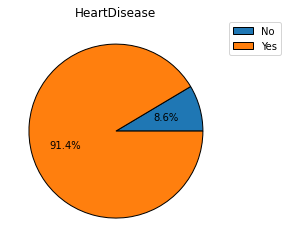

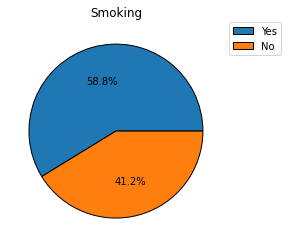

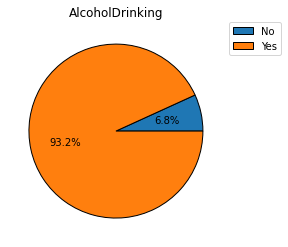

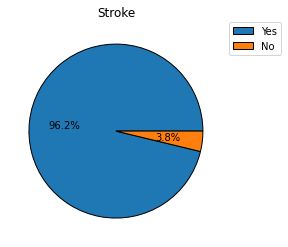

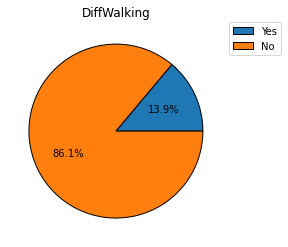

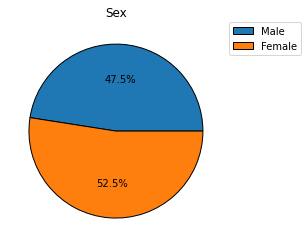

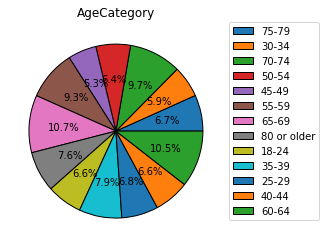

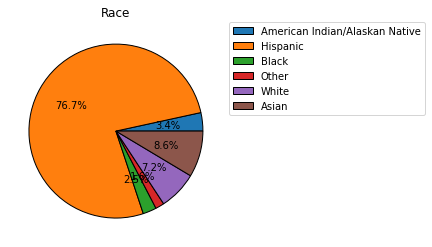

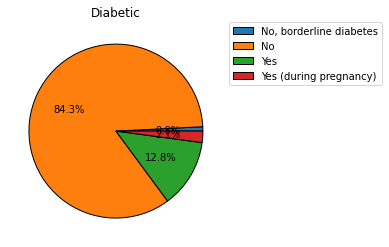

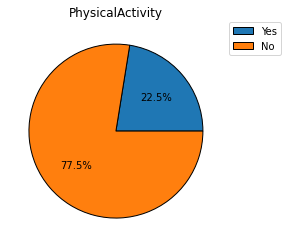

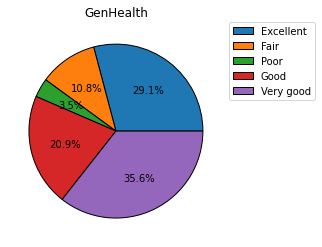

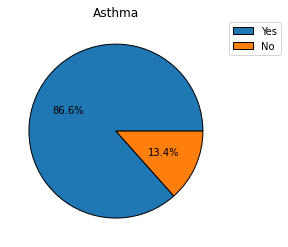

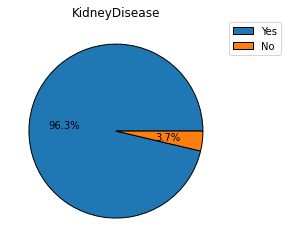

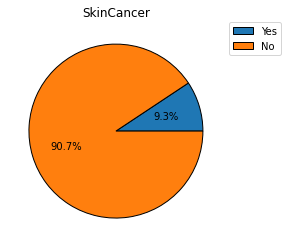

In [15]:
for i in range(0,len(data[string_col].columns)): #a range from 0 to the total number of catagorical columns
    fig, axes = plt.subplots(ncols=1) #creating block of one column to contain each pie graph seperately.
    axes.pie(percentage[i], autopct='%1.1f%%', wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'black' }) # Creating the chart and selecting the parameters
    axes.set_title(string_col[i])    #adding a title to each plot

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = catagories[i]) #adding legend to the upper left of each pie chart   
    plt.show()

#### 2.3.6.1 Numerical Columns.

Below it is the "summary" method is excuted on the numerical fields.

In [16]:
data.select(numeric_col).summary().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|               BMI|    PhysicalHealth|     MentalHealth|         SleepTime|
+-------+------------------+------------------+-----------------+------------------+
|  count|            319795|            319795|           319795|            319795|
|   mean|28.325398520925823|3.3717100017198516|3.898366140808956| 7.097074688472302|
| stddev| 6.356100200470757| 7.950850182571344|7.955235218943571|1.4360070609642777|
|    min|             12.02|                 0|                0|                 1|
|    25%|             24.03|                 0|                0|                 6|
|    50%|             27.34|                 0|                0|                 7|
|    75%|             31.42|                 2|                3|                 8|
|    max|             94.85|                30|               30|                24|
+-------+------------------+------------------+-----------------+

The final step is to create a pair plot between all the numerical columns in order to determine whether there are any anomalies or whether there is any direct correlation that can be observed easily. The "pairplot" method from the "seaborn" library was used to plot the data, and the data was sampled using the "sample" method to only take half of the data due to the large number of rows, as this method may require a substantial amount of processing time, especially if it is replicated on even larger datasets.

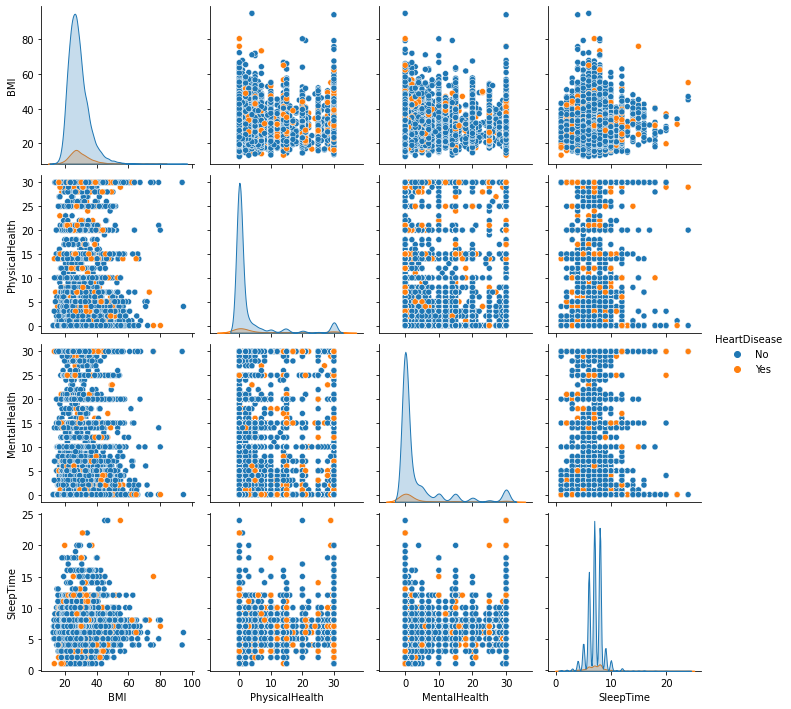

In [17]:
sample = data.sample(False, 0.1,seed=4).toPandas() #taking only a sample of the dataset
sns.pairplot(sample, hue="HeartDisease")
plt.show()

From the plots above, there is not much we can conclude, however, the data is now ready for the next step. In addition, we have become familiar with the dataset and have ensured that there are no noises or inaccuracies within it. 

## 2.4 Machine Learning and Predictive Analysis

The purpose of this section is to answer the research questions of this paper using machine learning algorithms. In brief, I sought to 
determine if the selected variables, such as BMI, smoking, age group, etc., could be used to predict the occurrence of heart disease.
For these questions I'm seeking a yes/no answer meaning whether people have heart disease or not. Therefore, the most suitable machine learning algorithms are binary classifications algorithms. Among the most popular are: Logistic Regression, k-Nearest Neighbors, Decision Trees, Support Vector Machine and Naive Bayes.<br>
This paper will focus on the investigation of three of these methods: Logistics Regression, Decision Trees (Random Forest), and Naive Bayes, to determine which method performs the best in predicting the probability of having heart disease and extract 
featuer importance for the variables.<br>

### 2.4.1 Reshaping the Dataset for Machine Learning Algorithm
Pyspark's machine learning library accepts input in a certain manner, requiring a label, which is the column or feature we wish to predict, 
and a collection of features to be used in the prediction. The data can be formatted into labels and features using the 
Vector Assembler library. Further, the machine learning algorithms are based solely on numerical features, hence, 
String Indexer and One Hot Encoding can be used to convert categorical/string columns into numeric values.<br>
Lastly, once the above steps have been completed and the new dataset is ready, it must be separated into two pieces, one for training the model and one for evaluating its accuracy.

In [18]:
#recall the list of the string columns and the numeric ones 
print("String Columns: ",string_col)
print("Numeric Columns: ",numeric_col)

# we remove HeartDisease since we want to handle it seperately as we want it to be a label rather than part of the feautres
catagorical_col = string_col[1:] 
print("Catagorical Columns: ",catagorical_col)

String Columns:  ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
Numeric Columns:  ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Catagorical Columns:  ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']


In [19]:
#I aim to use the pipeline feature of pyspark, hence, we put all of the stages of the transformation from catagorical to numerical in the stages list
#as we know pyspark has a lazy evaluation meaning it will not run until an action is called.

stages=[] #declaring an empty list to input our transformation steps one by one
for col in catagorical_col: #looping through the catagorical columns
    string_indexer = StringIndexer(inputCol = col, outputCol = col+"_indx") #converting the values into indices
    encoder = OneHotEncoder(inputCols = [string_indexer.getOutputCol()], outputCols = [col+"_catVec"]) #converting the data to onehotecncoder values
    stages += [string_indexer, encoder] #adding above to the stages of the pipeline
assembler_in = [col + "_catVec" for col in catagorical_col] + numeric_col #Compiling all the columns together processed catagorical and numeric once

vectassemble = VectorAssembler(inputCols = assembler_in, outputCol = "features") #using assembler to prcess the data into label and feauter 
stages += [vectassemble] #adding vector assembler to the stages of the pipeline

label_indexer = StringIndexer(inputCol="HeartDisease", outputCol="label") #changing the name of the column that needs prediction to label, as it is the standard name
stages += [label_indexer]

In [20]:
pipeline = Pipeline (stages = stages) #declaring the stages that we want to add to the pipeline
pipelineModel = pipeline.fit(data) #run the pipeline on the data
data_fit = pipelineModel.transform(data) #finally transofrming the data
data_final = data_fit.select(['features','label']) #select only features and labels from the dataset as those are the only relavent fields for pyspark machine learning

In [21]:
data_final.show(truncate=False) #truncate=false was used to ensure that all content of the rows are visible.

+---------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                             |label|
+---------------------------------------------------------------------------------------------------------------------+-----+
|(37,[1,2,3,4,8,17,23,25,26,31,33,34,35,36],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.6,3.0,30.0,5.0])              |0.0  |
|(37,[0,1,3,4,10,17,22,25,26,30,31,32,33,36],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.34,7.0])             |0.0  |
|(37,[1,2,3,5,17,23,25,29,31,32,33,34,35,36],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,26.58,20.0,30.0,8.0])           |0.0  |
|(37,[0,1,2,3,4,12,17,22,27,30,31,33,36],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.21,6.0])                     |0.0  |
|(37,[0,1,2,4,14,17,22,25,26,30,31,32,33,34,36],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,23.71,28.0,8.0])     

In [22]:
#splitting the data %70 for training and 30% for testing
train_data, test_data = data_final.randomSplit([0.7,0.3]) 

### 2.4.2 Executing the Models

In this section, the steps necessary to run three selected machine learning classification models will be implemented: Logistic Regression, Naive Bayes, and Random Forest.
Cross validation is used to re-run the models with different parameters and return the results from the most accurate run, then use the model to transform the test data and make it ready for evaluation.

#### 2.4.2.1 Implementation of Logistic Regression Model

The logistic regression is a popular machine learning models, it is based on regresssion analysis and suits predictive
analysis, best used to conduct regression analysis on binary variable.
The logistic regression takes two main parameters, regularisation (regParam) and elastic net (elasticNetParam). If the regularisation value is set above zero and the elastic net is zero, the regression is rigid, it is mostly 
recommended for datasets containing multicollinearity variables, whereas if the regularization value is greater than zero and the elastic net is one, it is called LASSO regression which is more suitable for datasets with a lot of variables.
Cross validation technique is used to pass different parameters to the regression model and test the parameters sequentially, in order to identify the most accurate model.(Alpaydin, E 2014)

In [23]:
#declaring the model
lr = LogisticRegression(featuresCol = 'features', labelCol = "label", maxIter=100)

In [24]:
#defining the different parameters
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1]) #0 is LASSO and 1 is rigid 
             .build())

In [25]:
#building the cross validation model
crossval = CrossValidator(estimator=lr,
                         estimatorParamMaps = lr_paramGrid,
                         evaluator=BinaryClassificationEvaluator(), #by default it returns AUC value
                         numFolds = 5)

In [26]:
#fitting the model onto the training data
lr_cv_model = crossval.fit(train_data) 

In [27]:
#checking the AUC of each for iteration of the process
lr_cv_model.avgMetrics 

[0.8304262378795679,
 0.6932119718927723,
 0.5,
 0.8236486468715998,
 0.5,
 0.5,
 0.8210063463220376,
 0.5,
 0.5]

In [28]:
#selecting the best model with best AUC
best_lr_cv_model = lr_cv_model.bestModel
#displaying the parameters of the selected model
best_lr_cv_model.extractParamMap()

{Param(parent='LogisticRegression_ac94f464ae60', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_ac94f464ae60', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_ac94f464ae60', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_ac94f464ae60', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_ac94f464ae60', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_ac94f464ae60', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_ac94f464ae60', name='maxIter', doc='max number of iterations (>= 0).'):

<div class="alert-success">The Ridge regression tunning performed the best with elastic net parameter at 0 and penalty parameter (regparam) at 0.1</div>

In [29]:
#using the model on the test data to make predictions
lr_cv_pred = lr_cv_model.transform(test_data)

In [30]:
lr_cv_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(37,[0,1,2,3,4,5,...|  0.0|[3.04158857617620...|[0.95441798900658...|       0.0|
|(37,[0,1,2,3,4,5,...|  0.0|[2.95593287559876...|[0.95054314481836...|       0.0|
|(37,[0,1,2,3,4,5,...|  0.0|[3.00981469979481...|[0.95301555784861...|       0.0|
|(37,[0,1,2,3,4,5,...|  0.0|[2.91684201813770...|[0.94867274590480...|       0.0|
|(37,[0,1,2,3,4,5,...|  0.0|[2.91643948786218...|[0.94865314205158...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [31]:
#the model is ready for evaluation.

#### 2.4.3 Implementation of Naive Bayes

In Naive Bayes classification, the test point is classified according to the probability that it belongs to a given class rather than by its label. While many ML algorithms are capable of performing both Regression and Classification tasks, this algorithm can only be used for Classification tasks.(Alpaydin, E 2014)<br>
In order to avoid situations of zero probability, a smoothing parameter is added to the model, 
cross validation was used to run the model at various smoothing factors between 0 and 1, and select the model that is most accurate.

In [32]:
#declare the naive bayes model
#since there have more than one feature the parameter "multinomial" need to be passed as model type
nb = NaiveBayes(featuresCol = 'features', labelCol = "label", modelType="multinomial") 

In [33]:
#defining the different parameters
nb_cv_paramGrid = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0.0, 0.4, 0.8, 1.0]) #smoothing factor
             .build())

In [34]:
#building the cross validation model
nb_crossval = CrossValidator(estimator = nb,
                         estimatorParamMaps = nb_cv_paramGrid,
                         evaluator=BinaryClassificationEvaluator(),
                         numFolds = 5)

In [35]:
#fitting the model onto the training data
nb_cv_model = nb_crossval.fit(train_data) 

In [36]:
#checking the AUC of each iteration of the process
nb_cv_model.avgMetrics

[0.4967801827227897,
 0.49676975449037364,
 0.49675462864043496,
 0.4967481095227519]

In [37]:
#displaying the parameters of the selected model
nb_cv_model.bestModel.extractParamMap()

{Param(parent='NaiveBayes_ead23a6e41c8', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='NaiveBayes_ead23a6e41c8', name='labelCol', doc='label column name.'): 'label',
 Param(parent='NaiveBayes_ead23a6e41c8', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'multinomial',
 Param(parent='NaiveBayes_ead23a6e41c8', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='NaiveBayes_ead23a6e41c8', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='NaiveBayes_ead23a6e41c8', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='NaiveBayes_ead23a6e41c8', name='smoothing', doc

<div class="alert-success">Based on the average metrics, it was determined that the model with smoothing parameter 1 was the best predictor. However, looking at average metrics, there does not appear to be much variation in the nuscors.</div>

In [38]:
#using the model on the test data
nb_cv_pred = nb_cv_model.transform(test_data)

In [39]:
nb_cv_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(37,[0,1,2,3,4,5,...|  0.0|[-94.433339527827...|[0.99650427269552...|       0.0|
|(37,[0,1,2,3,4,5,...|  0.0|[-179.08024093259...|[0.67282874815432...|       0.0|
|(37,[0,1,2,3,4,5,...|  0.0|[-102.25884638919...|[0.99816556294883...|       0.0|
|(37,[0,1,2,3,4,5,...|  0.0|[-189.08311338425...|[0.33318921407045...|       1.0|
|(37,[0,1,2,3,4,5,...|  0.0|[-141.91013874979...|[0.62215769082015...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [40]:
#the model is ready for evaluation.

#### 2.4.4 Implimentation of Random Forest Model

A Random Forest is a classifier that uses a series of decision trees on various subsets of a dataset and measures their predictive accuracy according to the average of the trees. In place of relying on one decision tree, it takes into account the decisions of a 
majority of trees. (Machine learning random forest algorithm - javatpoint. www.javatpoint.com. (n.d.). Retrieved August 22, 2022)

In [41]:
#declare the random forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [42]:
#defining the different parameters
rf_paramGrid = (ParamGridBuilder()
            .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 25, num = 3)]) \
            .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
             .build())

In [43]:
#building the cross validation model
rf_crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [44]:
#fitting the model onto the training data
rf_cv_model = rf_crossval.fit(train_data) 

In [45]:
#checking the AUC of each iteration of the process
rf_cv_model.avgMetrics

[0.7716859040443401,
 0.8156756980907909,
 0.8276121337046738,
 0.7808735614575262,
 0.8198708415613964,
 0.8307229239155444,
 0.7843355700987866,
 0.8196953384651068,
 0.8318558957986693]

In [46]:
#displaying the parameters of the selected model
rf_cv_model.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_a57c34fe01b3', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_a57c34fe01b3', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_a57c34fe01b3', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_a57c34fe01b3', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [47]:
#using the model on the test data
rf_cv_pred = rf_cv_model.transform(test_data)

In [48]:
rf_cv_pred.show(5,truncate = False)

+----------------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------+-----------------------------------------+----------+
|features                                                                                                                    |label|rawPrediction                          |probability                              |prediction|
+----------------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------+-----------------------------------------+----------+
|(37,[0,1,2,3,4,5,17,22,25,26,30,31,32,33,34,35,36],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.6,2.0,2.0,7.0])  |0.0  |[24.48355720084916,0.5164427991508463] |[0.9793422880339662,0.020657711966033852]|0.0       |
|(37,[0,1,2,3,4,5,17,22,25,26,30,31,32,33,34,35,36],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [49]:
#the model is ready for evaluation.

### 2.4.3 Evaluation of the Models
To evaluate a binary classification models implemented in previous section, a number of standard measures are available for 
evaluating the models, including Area under receiver operating characteristic curve (ROC) curve (AUC), F1-score, precision, recall, and the number of false positive and false negative predictions.
(Canbek, Gürol & Sagiroglu, Seref & Taskaya Temizel, Tugba & Baykal, Nazife, 2017)<br>
Each evaluation metric is defined and explained as follows:<br><br>
ROC: is the plot between the true and false positive.<br>
AUC: is the area under the curve, the higher it is the higher ratio of true positive exists.<br>
precision: is the number of true positive results divided by the number of all positive results, including those not identified correctly.<br>
Recall: is the number of true positive results divided by the number of all samples that should have been identified as positive.<br>
F-1 Score: is the score of harmonic mean of the precision and recall.<br><br>

I begin by creating ROC curves for all of the models. I use a method shared publicly by databrick to calculate the true and false positives for each point across all models and plot them on a line graph to visualize their performance. 
With the binary classification evaluator, we calculated the AUC, and with the multiclass classification evaluator, we calculated precision, recall, and F1-score. Furthermore, we will extract the number of true and false positives/negatives and summarizing them in a dataframe to determine the most effective model.


#### 2.4.3.1 Plot ROC Curve 

In [50]:
#this method is highly inspired from an approch implemented on databricks
#https://www.alicehuacal.com/project/flight-delay-prediction/html/model_261

class CurveMetrics(BinaryClassificationMetrics):
  """
  Ref: shorturl.at/grLMO|
  Helper function to plot pr & roc curves
  """
  def __init__(self, *args):
    super(CurveMetrics, self).__init__(*args)
  def _to_list(self, rdd):
    points = []
    # Note this collect could be inefficient for large datasets 
    # considering there may be one probability per datapoint (at most)
    # The Scala version takes a numBins parameter, 
    # but it doesn't seem possible to pass this from Python to Java
    for row in rdd.collect():
        # Results are returned as type scala.Tuple2, 
        # which doesn't appear to have a py4j mapping
        points += [(float(row._1()), float(row._2()))]
    return points
  def get_curve(self, method):
    rdd = getattr(self._java_model, method)().toJavaRDD()
    return self._to_list(rdd)

In [51]:
#the probablity column contains two values which is the likelihood probablity and unlikelihood
#for calculating ROC we only need the probablity of likelihood, hence, we extract is as below
preds_lr = lr_cv_pred.rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))) #logistic Regression model
preds_cv = nb_cv_pred.rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))) #NV model
preds_rf = rf_cv_pred.rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))) #Random Forest Model

In [52]:
#Run the method that is defined in the previous block on probability for each model. 
points_lr = CurveMetrics(preds_lr).get_curve('roc')
points_nb = CurveMetrics(preds_cv).get_curve('roc')
points_rf = CurveMetrics(preds_rf).get_curve('roc')

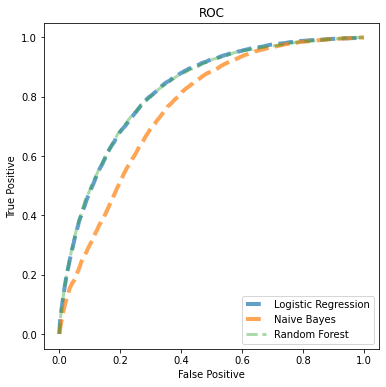

In [53]:
plt.rcParams["figure.figsize"] = (6,6) #determine the size of the figure
plt.figure() #initate the size change

#converting each column from each model to a list
x_lr = [x[0] for x in points_lr]
y_lr = [x[1] for x in points_lr]
x_nb = [x[0] for x in points_nb]
y_nb = [x[1] for x in points_nb]
x_rf = [x[0] for x in points_rf]
y_rf = [x[1] for x in points_rf]

#adding title and labels
plt.title("ROC") 
plt.xlabel("False Positive")
plt.ylabel("True Positive")

#creating the plots x,y, label, alpha =transparency, lw = line width, linestyle)
plt.plot(x_lr, y_lr, label = "Logistic Regression", alpha=0.7, lw=4,linestyle='dashed')
plt.plot(x_nb, y_nb, label = "Naive Bayes", alpha=0.7, lw=4, linestyle='dashed')
plt.plot(x_rf, y_rf, label = "Random Forest", alpha=0.4, lw=3, linestyle='dashed')

#initiating the plot with legend referenced by the label parameter in plt.plot
plt.legend()
plt.show()

#### 2.4.3.2 Evaluation Matrix Table

In [54]:
#declaring the different evaluators from the BinaryClassificationEvaluator library
evaluator_ROC = BinaryClassificationEvaluator(metricName="areaUnderROC")
evaluator_ACC = MulticlassClassificationEvaluator(metricName="accuracy")
evaluator_F1 = MulticlassClassificationEvaluator(metricName="f1")
evaluator_PRECI = MulticlassClassificationEvaluator(metricName="precisionByLabel")
evaluator_RECAL = MulticlassClassificationEvaluator(metricName="recallByLabel")

#Compile the prediction of each model into a list
all_predictions = [lr_cv_pred,nb_cv_pred, rf_cv_pred] 

#Create a list of all the metrics to be used to generate the dataframe with the metrics
metrics_names = ["AUC", "Accuracy", "F1", "Precision", "Recall", "True Negative", "True Postive", "False Negative", "False Positive"] #title of the metrics

#creat a funtion to calculate all of the evaluation metrics
def evaluations(df):
    roc = evaluator_ROC.evaluate(df)
    acc = evaluator_ACC.evaluate(df)
    f1 = evaluator_F1.evaluate(df)
    preci = evaluator_PRECI.evaluate(df)
    recal = evaluator_RECAL.evaluate(df)
    TN = df.filter('prediction = 0 AND label = prediction').count()
    TP = df.filter('prediction = 1 AND label = prediction').count()
    FN = df.filter('prediction = 0 AND label <> prediction').count()
    FP = df.filter('prediction = 1 AND label <> prediction').count()
    return [float(roc),float(acc),float(f1),float(preci),float(recal),float(TN),float(TP),float(FN),float(FP)]
    

In [55]:
#run the function and place the data into a new list
metric_values = [evaluations(i) for i in all_predictions]

In [56]:
#convert the results of the function into a dataframe with their corresponding title.
all_met = sq.createDataFrame(zip(metrics_names,metric_values[0],metric_values[1],metric_values[2]), ["Metrics", "Logistic Regression","Naive Bayes","Random Forest"])
all_met.show()

+--------------+-------------------+------------------+------------------+
|       Metrics|Logistic Regression|       Naive Bayes|     Random Forest|
+--------------+-------------------+------------------+------------------+
|           AUC| 0.8261103349427744| 0.496012067885675|0.8254988739801195|
|      Accuracy| 0.9153800319872887|0.8385478189059511|0.9153382185379928|
|            F1| 0.8782133596350161|0.8536841326103183|0.8833840252907785|
|     Precision| 0.9163414736488754|0.9337781846213143| 0.918966281696683|
|        Recall| 0.9986281481142752| 0.886284910772467|0.9951642221028203|
| True Negative|            87353.0|           77526.0|           87050.0|
|  True Postive|              215.0|            2692.0|             514.0|
|False Negative|             7975.0|            5498.0|            7676.0|
|False Positive|              120.0|            9947.0|             423.0|
+--------------+-------------------+------------------+------------------+



The metrics indicate that logistic regression and random forest have higher rates across all metrics compared to Naive Bayes. Furthermore, In all metrics, random forest outperformed logistic regression, however, logistic regression was more accurate in predicting true negatives, while random forest was more accurate in predicting true positives.

### 2.4.4 Feature Importance
For both of the accurate predictive models, Logistic Regression and Random Forest, I will calculate the importance value of the parameter (columns) and see which had the most effect on the machine learning model.
Random forest models have a method for determining the importance of a feature directly, whereas logistics regulation uses a coefficient that calculates how the predictor is related to the parameter, which means that the higher the coefficient, the more important the feature is.
I begin by defining a function that will obtain the parameters and convert them into a pandas dataframe. I run the function twice, once for the logistic regression model and once for the random forest model.

In [57]:
#This function was inspired by function found on https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x]) #abs is used to ensure the values are returned are positive.
    return(varlist.sort_values('score', ascending = False))

#### 2.4.4.1 Display Logistic Regression Feature Importance

In [58]:
ExtractFeatureImp(lr_cv_model.bestModel.coefficients, lr_cv_pred, "features").head(37)

,idx,name,score
14,10,AgeCategory_catVec_80 or older,0.621680
16,12,AgeCategory_catVec_75-79,0.465352
11,7,AgeCategory_catVec_70-74,0.336591
27,23,Diabetic_catVec_Yes,0.323567
33,29,GenHealth_catVec_Fair,0.323108
9,5,AgeCategory_catVec_65-69,0.191698
5,1,AlcoholDrinking_catVec_No,0.131593
21,17,Race_catVec_White,0.089478
31,27,GenHealth_catVec_Good,0.072119
10,6,AgeCategory_catVec_60-64,0.061190


#### 2.4.4.1 Display Random Forest Feature Importance

In [59]:
ExtractFeatureImp(rf_cv_model.bestModel.featureImportances, rf_cv_pred, "features").head(37)

,idx,name,score
6,2,Stroke_catVec_No,0.096753
0,33,BMI,0.089318
7,3,DiffWalking_catVec_No,0.081229
1,34,PhysicalHealth,0.076322
3,36,SleepTime,0.065534
27,23,Diabetic_catVec_Yes,0.059017
14,10,AgeCategory_catVec_80 or older,0.050763
2,35,MentalHealth,0.047096
33,29,GenHealth_catVec_Fair,0.042070
8,4,Sex_catVec_Female,0.040337



## The End